# Collocational analysis for semantic change

Based on https://github.com/BarbaraMcG/latinise/blob/master/lvlt22/lvlt22_collocs-aligned.ipynb

Aim: compare e.g. first 5/10 co-occurring terms for pre- and post- Christian period, and then compare same items in Christian vs. non-Christian corpora.


## Packages

In [89]:
# general
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import time
import re
import itertools
import pickle
import csv

In [2]:
# clustering algorithms, distance metrics
from sklearn.cluster import DBSCAN,KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
# networks
import networkx as nx
from pyvis import network
from pyvis.network import Network

In [3]:
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [4]:
# corpus readers, coocurrences and word vectors
from nltk.collocations import *
import nltk
import pickle
#from cltk.stops import lat as lat_stops
#import cltk
from nltk.util import skipgrams
from nltk.lm import NgramCounter
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.similarities import MatrixSimilarity

from utils_KN.data.buildCollocs import BuildCollocs
from utils_KN.data.readCorpus import NltkCorpusFromDir, CorpusFromDir, NltkCorpusFromList
from utils_KN.data.buildModels import BuildModels
from utils_KN.data.collDiffs import collDiffs
from nltk.corpus.reader.plaintext import PlaintextCorpusReader, CategorizedPlaintextCorpusReader
from nltk.tokenize.simple import SpaceTokenizer, LineTokenizer
from nltk.text import Text, TextCollection

If the `rebuild` parameter is set to `True` we will rerun the most resource-consuming code instead of reading the pre-computed variables from pickles.

In [5]:
rebuild = False

## Terms
We are interested in semantic change patterns of a set of terms related to Christianity, such as:

In [6]:
christian_terms = ["scriptura", "lectio", "deus", "dominus", "creator", "factor", "deductor", "oratio", "lex", "altarium", "tabernaculum", "memoria", "recessus", "frater", "soror", "canticum", "virtus", "gratia", "gloria", "panis", "anima","sanctus", "beatus"]
christian_terms_2 = ["communico", "benedico", "commoror", "suscipio", "deputo", "poto"]
print(christian_terms)

['scriptura', 'lectio', 'deus', 'dominus', 'creator', 'factor', 'deductor', 'oratio', 'lex', 'altarium', 'tabernaculum', 'memoria', 'recessus', 'frater', 'soror', 'canticum', 'virtus', 'gratia', 'gloria', 'panis', 'anima', 'sanctus', 'beatus']


We're assigning each term a seperate colour to facilitate our analyses.

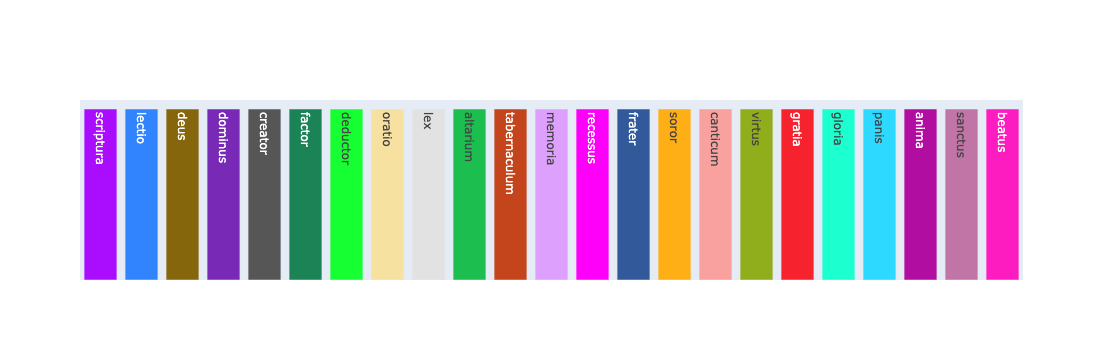

In [7]:
color_discrete_map_terms = { term : px.colors.qualitative.Alphabet[i] for i, term in enumerate(christian_terms)} # for each term we fix a color
fig = go.Figure()
fig.add_trace(go.Bar(
    x = [col for col in color_discrete_map_terms.keys()],
    y = [0.5 for x in range(0, len(color_discrete_map_terms)) ],
    text = christian_terms,
    textangle=90,
    marker_color=[col for col in color_discrete_map_terms.values()]
))
fig.update_layout(showlegend=False, xaxis={'showgrid': False, 'visible': False}, yaxis={'showgrid': False, 'visible': False})

## The corpus

The corpus processing phase follows as close as possible BMG's workflow to keep models compatible. There are 2 exceptions:

- all lemmas are converted to lowercase and
- anomalous lemmas (mostly punctuation) are added to stopword list.

In [8]:
# corpus files (after removing duplicates between IT and MQDQ)
dir_input =  os.path.join("/Users", "valentinalunardi", "Documents", "UCLA_PhD", "Thesis", "Metadata_corrections")
dir_in = os.path.join(dir_input, "preprocessed_lemmas_2024")
dir_in_words = os.path.join(dir_input, "preprocessed_tokens_2024")    
files = os.listdir(os.path.join(dir_in))

#### Process the metadata
We'll be storing corpus metadata in a data frame.

In [9]:
# metadata (after removing duplicates between IT and MQDQ and corrected dates until roughly the augustan age)
metadata_df = pd.read_csv(os.path.join(dir_input, 'latinise_metadata_2024.csv'), sep = ",")
metadata_df.head()

id                title                  creator  date    type  \
0  IT-LAT0261       Carmen Saliare        [Auctor incertus]  -650  poetry   
1  IT-LAT0285  XII Tabularum Leges        [Auctor incertus]  -450   prose   
2  IT-LAT0262        Carmen Arvale        [Auctor incertus]  -350  poetry   
3    MQDQ-288   carminum fragmenta  Caecus, Appius Claudius  -290  poetry   
4  IT-LAT1006            Praecepta    Marcius Vates, Gnaeus  -229   prose   

                       file  
0   lat_0350_IT-LAT0261.txt  
1  lat_-0450_IT-LAT0285.txt  
2   lat_0350_IT-LAT0262.txt  
3    lat_-0300_MQDQ-288.txt  
4  lat_-0229_IT-LAT1006.txt

Convert dates to integers:

In [10]:
metadata_df["date"] = metadata_df["date"].astype('int') #ensure we're working with integers
metadata_df.dtypes

id         object
title      object
creator    object
date        int64
type       object
file       object
dtype: object

In [11]:
first_date = -300

In [12]:
last_date = 600

Define size of the time intervals:

In [13]:
size_interval = 450

So there are

In [14]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

2

time intervals.

Define the time periods and split the corpus:

In [15]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)
periods_labels = [ str(p1) + '-' + str(p2) for p1, p2 in zip(intervals, intervals[1:]) ]
print(periods_labels)

[-300, 150, 600]
['-300-150', '150-600']


Add a column to the metadata_df for the time interval:

In [16]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-300, 150)
3     -290
4     -229
5     -225
6     -225
7     -225
      ... 
415    116
416    116
417    121
418    147
419    147
Name: date, Length: 417, dtype: int64
1
range(150, 600)
420    150
421    150
422    150
423    150
424    150
      ... 
889    594
890    598
891    598
892    598
893    598
Name: date, Length: 474, dtype: int64


id                                              title  \
0     IT-LAT0261                                     Carmen Saliare   
1     IT-LAT0285                                XII Tabularum Leges   
2     IT-LAT0262                                      Carmen Arvale   
3       MQDQ-288                                 carminum fragmenta   
4     IT-LAT1006                                          Praecepta   
...          ...                                                ...   
1242  IT-LAT0446                   Sacramentorum sanctitatis tutela   
1243  IT-LAT0536                                   Misericordia Dei   
1244  IT-LAT0762                            Ecclesia de Eucharistia   
1245  IT-LAT0839                Instructio Redemptionis Sacramentum   
1246  IT-LAT0840  Missa pro Ecclesia Primum nuntium post concele...   

                                                creator  date    type  \
0                                     [Auctor incertus]  -650  poetry   
1                                     [Auctor incertus]  -450   prose   
2                                     [Auctor incertus]  -350  poetry   
3                               Caecus, Appius Claudius  -290  poetry   
4                                 Marcius Vates, Gnaeus  -229   prose   
...                                                 ...   ...     ...   
1242                              Ioannes Paulus PP. II  2002   prose   
1243                              Ioannes Paulus PP. II  2002   prose   
1244                              Ioannes Paulus PP. II  2003   prose   
1245  Congregatio de Cultu Divino et Disciplina Sacr...  2004   prose   
1246                                     Benedictus XVI  2005   prose   

                          file time_interval  
0      lat_0350_IT-LAT0261.txt                
1     lat_-0450_IT-LAT0285.txt                
2      lat_0350_IT-LAT0262.txt                
3       lat_-0300_MQDQ-288.txt          -300  
4     lat_-0229_IT-LAT1006.txt          -300  
...                        ...           ...  
1242   lat_2002_IT-LAT0446.txt                
1243   lat_2002_IT-LAT0536.txt                
1244   lat_2003_IT-LAT0762.txt                
1245   lat_2004_IT-LAT0839.txt                
1246   lat_2005_IT-LAT0840.txt                

[1247 rows x 7 columns]

In [17]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

### Read in corpus files

In [18]:
# prepare the corpus
punctuation = ['.', ',', '...', ';', ':', '?', '(', ')', '-', '!', '[', ']', '"', "'", '""', '\n', '']

In [19]:
# define corpus subset
corpus_subset = metadata_df[(metadata_df['date'] >= first_date) & (metadata_df['date'] <= last_date)].copy().reset_index(drop=True)
filenames_subset = corpus_subset['file'] 

In [20]:
class NltkCorpusFromDirNew(PlaintextCorpusReader):
    "A subclass of NLTK PlaintextCorpusReader"
    
    word_tokenizer=SpaceTokenizer() # tokenize on whitespace
    sent_tokenizer=LineTokenizer() # assume sentence per line
    
    def __init__(
        self,
        root,
        fileids,
        encoding="utf8",        
        word_tokenizer=word_tokenizer,
        sent_tokenizer=sent_tokenizer,
        tolower=False, punctuation=None
    ):

        PlaintextCorpusReader.__init__(self, root=root, fileids=fileids, encoding=encoding,
                                       word_tokenizer=word_tokenizer,
                                       sent_tokenizer=sent_tokenizer)
        self.tolower = tolower
        self.punctuation = punctuation
        
    def _read_word_block(self, stream):
        words = []
        for i in range(20):  # Read 20 lines at a time.
            if self.punctuation is not None:
                words.extend( [ token.lower() if self.tolower == True else token for token 
                               in self._word_tokenizer.tokenize(stream.readline()) 
                               if token not in self.punctuation and token != '' 
                              ])
            else:
                words.extend( [ token.lower() if self.tolower == True else token for token in self._word_tokenizer.tokenize(stream.readline()) ])
        return words

In [21]:
#prepare the corpus
latinise = NltkCorpusFromDirNew(root=dir_in, fileids=filenames_subset,
                                punctuation=punctuation, tolower=True)
latinise_docs = []
for fileid in latinise.fileids():
    latinise_docs.append(Text(latinise.words(fileid)))
print("This corpus contains ", len(latinise_docs), " documents.")

This corpus contains  892  documents.


In [22]:
corpus = list()
for sent in latinise.sents():
    corpus.append(token.lower() for token in sent if token not in punctuation and token != '')

### Splitting the corpus
The corpus is split into slices, each covering `size_interval` years.

In [23]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals):
    files_corpus_t = list(corpus_subset.loc[corpus_subset['time_interval'] == intervals[t]]["file"])
    print("retrieving the subcorpus for interval ", intervals[t])
    sents = latinise.sents(fileids=files_corpus_t)
    sents_clean = list()
    for sent in sents:
        sents_clean.append( [ token.lower()  for token in sent if token not in punctuation and token != ''  ] )
    time2corpus[t] = sents_clean

retrieving the subcorpus for interval  -300
retrieving the subcorpus for interval  150


The `time2corpus` variable is a dictionary with time slices as keys. Each item is a list of sentences, each being a list of lemmas.

In [24]:
print(f'Dictionary keys are: { [ period for period in time2corpus.keys()] }')
print('First 3 sentences from the 2nd corpus slice are: ', time2corpus[1][0:2])

Dictionary keys are: [0, 1]
First 3 sentences from the 2nd corpus slice are:  [['cogito', 'ego', 'et', 'cum', 'animus', 'meus', 'octavius', 'bonus', 'et', 'fidelis', 'contubernalis', 'memoria', 'recenseo', 'tantus', 'dulcedo', 'et', 'adfectio', 'homo', 'inhaeresco', 'ut', 'ipse', 'quodammodo', 'ego', 'video', 'in', 'praeteritus', 'redeo', 'non', 'is', 'quis#2', 'iam', 'transigo', 'et', 'decurro', 'sum', 'recordatio', 'revoco', 'ita', 'is', 'contemplatio', 'quantum', 'subtraho', 'sum', 'oculus', 'tantus', 'pectus', 'meus', 'atque', 'paene', 'intimus', 'sensus', 'inplicata', 'sum'], ['nec', 'inmeritum', 'discedo', 'vir', 'eximius', 'et', 'sanctus', 'inmensum', 'suus', 'desiderium', 'nos', 'relinquo', 'utpote', 'cum', 'et', 'ipse', 'tanto', 'noster', 'semper', 'amor', 'flagraverit', 'ut', 'et', 'in', 'ludicrum', 'et', 'seria', 'par', 'ego', 'voluntas', 'concino', 'idem', 'volo#1', 'vel', 'nolo', 'credo', 'unus', 'mens', 'in', 'duo', 'sum', 'divisor']]


### Retrieve collocations

#### Build list of n-grams and compute association strengths 

We're going to use functions available in the `nltk` package. In order to do so, we first need (1) to convert corpora into the `nltk`-compatible format. Next, from each corpus, we are (2) retrieving lists of n-grams which (3) we feed to the so-called *finders* which count n-grams, filter out stopwords, and apply association strength measures to frequency counts.

In [25]:
corpus_nltk = latinise
print(f"This corpus contains {len(corpus_nltk.sents())} sentences and {len(corpus_nltk.words())} words.")

This corpus contains 434570 sentences and 7034706 words.


First, we're retrieving 50 collocations computed on non-contiguous 5-grams of each term **in the entire corpus**.

In [46]:
if rebuild == True:    
    collocs = list()
    for term in christian_terms:
        print(f"\nBuilding finder for the term: {term}")
        colls = BuildCollocs(corpus_nltk, term=term, window=5, filtering=True, top=50)
        colls.getFinder()
        print(f"Getting top 50 collocations for the term: {term}")
        tops = colls.getAllNtops()
        collocs.append((term, tops))
        
        # saving collocation sets for the next generations
        with open('collocations_all.pickle', 'wb') as f:
            pickle.dump(collocs,f)
          
elif rebuild == False:
    with open('out/models/collocations_all.pickle', 'rb') as f:
        collocs = pickle.load(f)

Let's inspect the data structure: each 2-tuple contains:
- the term itself and
- a list of 2-tuples: (association_measure, list_of_collocates).

In [37]:
print("a term ==> ", collocs[0][0],
      "\n", "a list of collocation tuples ==> ", collocs[0][1][1] )

a term ==>  scriptura 
 a list of collocation tuples ==>  ('dice', [('scriptura', 'divinus'), ('sacrosanctus', 'scriptura'), ('secundum', 'scriptura'), ('scriptura', 'diuina'), ('divinus', 'scriptura'), ('scriptura', 'sanctus'), ('scriptura', 'testamentum'), ('lectio', 'scriptura'), ('scriptura', 'depositio'), ('huiusmodi', 'scriptura'), ('scriptura', 'canon'), ('scriptura', 'testor'), ('testamentum', 'scriptura'), ('scriptura', 'interpretatio'), ('quomodo', 'scriptura'), ('scriptura', 'praesentia'), ('canonicus', 'scriptura'), ('scriptura', 'secundum'), ('scriptura', 'caelestis'), ('propositum', 'scriptura'), ('locutio', 'scriptura'), ('scriptura', 'auctoritas'), ('scriptura', 'testator'), ('scriptura', 'lego#2'), ('scriptura', 'mentitur'), ('sanctus', 'scriptura'), ('scriptura', 'veritas'), ('scriptura', 'noto'), ('scriptura', 'ecclesiasticus'), ('scriptura', 'saecularis'), ('interpono', 'scriptura'), ('scriptura', 'expono'), ('scriptura', 'cano'), ('omnimodus', 'scriptura'), ('scrip

Now we'll retrieve collocations for every period of **the time-segmented corpus**.

In [47]:
if rebuild == True:
    # retrieve collocations for time slices
    collocs_time = list()
    for key, corp in time2corpus.items():
        # read the corpus into an NLTK-compatible format
        corp_nltk = NltkCorpusFromList(corp)
        print(f"\nBuilding for the corpus: {key}")
        print(f"This corpus contains {len(corp_nltk.sents())} sentences and {len(corp_nltk.words())} words.")
        for term in christian_terms:
            print(f"\nBuilding finder for the term: {term}")
            colls = BuildCollocs(corp_nltk, term=term, window=5, filtering=True, top=50)
            colls.getFinder()
            print(f"Getting top 50 collocations for the term: {term}")
            tops = colls.getAllNtops()
            collocs_time.append((key, term, tops))
        
        # saving collocation sets for the next generations
        with open('collocations_all_time.pickle', 'wb') as f:
            pickle.dump(collocs_time,f)

elif rebuild == False:
    with open('out/models/collocations_all_time.pickle', 'rb') as f:
        collocs_time = pickle.load(f)

The structure of the `collocs_time` is similar to `collocs`, as the list contains 3-tuples of (period, term, list_of_collocs):

`[ ( period_0, term_0, [(measure_0, [collocs_0])] ) ]`

In [39]:
print("period ==> ", collocs_time[0][0], "\n",
      "term ==> ", collocs_time[0][1], "\n",
      "a list of collocation tuples ==> ", collocs_time[0][2][0] )

period ==>  0 
 term ==>  scriptura 
 a list of collocation tuples ==>  ('chi_sq', [('inueterascerent', 'scriptura'), ('nolemus', 'scriptura'), ('scriptura', 'euanesceret'), ('scriptura', 'lllud'), ('scriptura', 'obseruari'), ('scriptura', 'spreuissem'), ('scriptura', 'tomus'), ('pantaleon', 'scriptura'), ('decumis', 'scriptura'), ('leon', 'scriptura'), ('scriptura', 'sursum'), ('scriptura', 'decumae'), ('conlocatio', 'scriptura'), ('enarro', 'scriptura'), ('scriptura', 'pecudem'), ('scriptura', 'portorium'), ('corneus', 'scriptura'), ('imaginum', 'scriptura'), ('relicum', 'scriptura'), ('scriptura', 'pompilius'), ('diligens', 'scriptura'), ('secures', 'scriptura'), ('adsidua', 'scriptura'), ('scriptura', 'versus'), ('ignorantia', 'scriptura'), ('musica', 'scriptura'), ('perplexus', 'scriptura'), ('scriptura', 'praeteritum'), ('promiscuus', 'scriptura'), ('scriptura', 'breui'), ('inspecto', 'scriptura'), ('poeta', 'scriptura'), ('dispositio', 'scriptura'), ('diurnus', 'scriptura'), ('t

#### Convert data for easy access
Let's now convert these data structures to dictionary for easier access.

In [40]:
# convert list of tuples into dict
collocs_dict = {}
for item in collocs:
    term = item[0]
    collocs_set = item[1]
    if collocs_dict.setdefault(term) is None:
        collocs_dict.setdefault(term)
        collocs_dict[term] = {}
    for coll in collocs_set:
        coeff = coll[0] # dice etc.
        colls = coll[1] # a list of collocs
        colls_only = [ list(filter(lambda w: w!=term, bigram)) for bigram in coll[1] ] # only collocates
        colls_only = [ x[0] if len(x) > 0 else term for x in colls_only ] # restores collocates which = term
        collocs_dict[term].setdefault(coeff, [])
        collocs_dict[term][coeff] = []
        collocs_dict[term][coeff].append(colls)
        collocs_dict[term][coeff].append(colls_only)

The collocations for each `term` and `association_measure` may be accessed as:
`collocs_dict[term][association_measure]`.
For example:

In [41]:
# inspect the dictionary
print(collocs_dict["scriptura"]["dice"])

[[('scriptura', 'divinus'), ('sacrosanctus', 'scriptura'), ('secundum', 'scriptura'), ('scriptura', 'diuina'), ('divinus', 'scriptura'), ('scriptura', 'sanctus'), ('scriptura', 'testamentum'), ('lectio', 'scriptura'), ('scriptura', 'depositio'), ('huiusmodi', 'scriptura'), ('scriptura', 'canon'), ('scriptura', 'testor'), ('testamentum', 'scriptura'), ('scriptura', 'interpretatio'), ('quomodo', 'scriptura'), ('scriptura', 'praesentia'), ('canonicus', 'scriptura'), ('scriptura', 'secundum'), ('scriptura', 'caelestis'), ('propositum', 'scriptura'), ('locutio', 'scriptura'), ('scriptura', 'auctoritas'), ('scriptura', 'testator'), ('scriptura', 'lego#2'), ('scriptura', 'mentitur'), ('sanctus', 'scriptura'), ('scriptura', 'veritas'), ('scriptura', 'noto'), ('scriptura', 'ecclesiasticus'), ('scriptura', 'saecularis'), ('interpono', 'scriptura'), ('scriptura', 'expono'), ('scriptura', 'cano'), ('omnimodus', 'scriptura'), ('scriptura', 'sursum'), ('scriptura', 'insinuo'), ('scriptura', 'interpr

In [1]:
# # Experimenting (mostly ChatGPT's work)
# # Whole corpus collocations

# # Step 1: Initialize the BuildCollocs object
# collocs2 = BuildCollocs(
#     corpus=corpus_nltk,
#     term=None,
#     window=5,
#     filtering=True,
#     ngram=2,            # Bigram example
#     measure="dice",     # Statistical measure
#     top=10,             # Top N collocations
#     contiguous=True
# )

# # Step 2: Generate the finder
# collocs2.getFinder()
# finder = collocs2.finder

# # Step 3: Select the statistical measure
# from nltk.collocations import BigramAssocMeasures  # Use your n-gram's specific measure
# measure = BigramAssocMeasures.dice

# # Step 4: Make dictionary to store results for each word
# collocations_by_word = {}

# # Step 5: Iterate through each word in the predefined set
# for word in christian_terms:
#     # Create a fresh finder object for each word to reset filters
#     collocs2.getFinder()
#     finder = collocs2.finder
    
#     # Filter the finder to include only collocations containing the word
#     finder.apply_ngram_filter(lambda *ngram: word not in ngram)
    
#     # Get the top-ranked bigrams containing the word
#     top_ngrams = finder.nbest(measure, 10)

#     # Get counts for each of the top n-grams
#     top_ngram_counts = [(ngram, finder.ngram_fd[ngram]) for ngram in top_ngrams]
    
#     # Sort the bigrams by frequency (count), descending order
#     sorted_ngram_counts = sorted(top_ngram_counts, key=lambda x: x[1], reverse=True)
    
#     # Store the sorted results in the dictionary
#     collocations_by_word[word] = sorted_ngram_counts

# # Step 6: Print the collocations for each word
# for word, collocations in collocations_by_word.items():
#     print(f"\nCollocations for '{word}':")
#     for ngram, count in collocations:
#         print(f"  N-gram: {ngram}, Count: {count}")

In [2]:
# # Ensure the directory exists
# os.makedirs(output_dir, exist_ok=True)

# # Define the full path for the CSV file
# csv_filename = os.path.join(output_dir, "collocations_count_all_time.csv")

# # Open the CSV file and write data
# with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
#     writer = csv.writer(file)
#     writer.writerow(["Target Word", "Bigram", "Count"])  # Header row

#     for word, collocations in collocations_by_word.items():
#         for ngram, count in collocations:
#             writer.writerow([word, f"{ngram[0]} {ngram[1]}", count])

# print(f"Collocation results saved to: {csv_filename}")

In [3]:
# Experimenting (mostly ChatGPT's work)
# # Time slice collocations

# from nltk.collocations import BigramAssocMeasures

# # Dictionary to store results across time slices
# collocs_time = []

# # Iterate through each time slice
# for time_key, corp in time2corpus.items():
#     print(f"\nProcessing time slice: {time_key}")

#     # Convert corpus into an NLTK-compatible format
#     corp_nltk = NltkCorpusFromList(corp)

#     # Print corpus details
#     print(f"This corpus contains {len(corp_nltk.sents())} sentences and {len(corp_nltk.words())} words.")

#     # Dictionary to store collocations for this time slice
#     collocations_by_word = {}

#     # Iterate over each target word
#     for word in christian_terms:
#         print(f"\nBuilding finder for the term: {word}")

#         # Initialize BuildCollocs for the current corpus
#         collocs2 = BuildCollocs(
#             corpus=corp_nltk,
#             term=None,  # Processing all words
#             window=5,
#             ngram=2,    # Bigrams
#             measure="dice",
#             top=10,     # Top N collocations
#             filtering=True,
#             contiguous=True
#         )

#         # Generate the finder
#         collocs2.getFinder()
#         finder = collocs2.finder

#         # Apply filter to only keep bigrams containing the target word
#         finder.apply_ngram_filter(lambda *ngram: word not in ngram)

#         # Get the top-ranked bigrams
#         top_ngrams = finder.nbest(BigramAssocMeasures.dice, 10)

#         # Get counts for each of the top n-grams
#         top_ngram_counts = [(ngram, finder.ngram_fd[ngram]) for ngram in top_ngrams]

#         # Sort bigrams by frequency (descending)
#         sorted_ngram_counts = sorted(top_ngram_counts, key=lambda x: x[1], reverse=True)

#         # Store results for this word
#         collocations_by_word[word] = sorted_ngram_counts

#     # Store results for this time slice
#     collocs_time.append((time_key, collocations_by_word))

# # Print a summary of results
# for time_key, collocations in collocs_time:
#     print(f"\nCollocations for time slice: {time_key}")
#     for word, bigrams in collocations.items():
#         print(f"\n  Collocations for '{word}':")
#         for ngram, count in bigrams:
#             print(f"    N-gram: {ngram}, Count: {count}")

In [4]:
# # Experimenting (mostly ChatGPT's work)
# # Time slice collocations
# # Specify the directory where you want to save the CSV
# output_dir = os.path.join("/Users", "valentinalunardi", "Documents", "UCLA_PhD", "Thesis", "Collocations", "out")

# # Ensure the directory exists
# os.makedirs(output_dir, exist_ok=True)

# # Define the full path for the CSV file
# csv_filename = os.path.join(output_dir, "collocations_count_time_slices.csv")

# # Open the CSV file and write data
# with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
#     writer = csv.writer(file)
#     writer.writerow(["Time Slice", "Target Word", "Bigram", "Count"])  # Header row

#     for time_key, collocations in collocs_time:
#         for word, bigrams in collocations.items():
#             for ngram, count in bigrams:
#                 writer.writerow([time_key, word, f"{ngram[0]} {ngram[1]}", count])

# print(f"Collocation results saved to: {csv_filename}")

## *Synchronic* collocations

Let's assume that the overlap between collocational sets of two or more words is indicative of their (dis)similarity. In this section, we are investigating synchronic collocation sets, that is collocations retrieved from the entire corpus. In the next sections, we'll be taking a closer look at diachronic overlap.

We choose for further analyses collocates retrieved with **Dice** coefficient as it usually yields the most interpretable results in manual corpus analysis (ie. content words, easy to understand syntagmatic and paradigmatic relation to node word).

In [42]:
labels = []
coll_sets = []
for coll_set in collocs_dict.items():
    labels.append(coll_set[0])
    coll_sets.append(coll_set[1]["dice"][1])
df = collDiffs.collDf(coll_sets, labels) #the df variable will be recycled
df.head(20)

colloc      slice rank
0         divinus  scriptura    1
1    sacrosanctus  scriptura    2
2        secundum  scriptura    3
3          diuina  scriptura    4
4         divinus  scriptura    5
5         sanctus  scriptura    6
6     testamentum  scriptura    7
7          lectio  scriptura    8
8       depositio  scriptura    9
9       huiusmodi  scriptura   10
10          canon  scriptura   11
11         testor  scriptura   12
12    testamentum  scriptura   13
13  interpretatio  scriptura   14
14        quomodo  scriptura   15
15     praesentia  scriptura   16
16      canonicus  scriptura   17
17       secundum  scriptura   18
18      caelestis  scriptura   19
19     propositum  scriptura   20

### Collocational overlap and semantic similarity

Let's look which terms overlap the most and the least.

In [43]:
# plotting looong ranking tables
def showLongTable(dataframe, show=True, color=None, colormap = None):    
    dataframe.iteritems()
    rowcolors = None
    if color is not None and colormap is not None:
        rowcolors = [ colormap[i] for i in dataframe[color] ]
    tbl = go.Table(
        header=dict(values=list(dataframe.columns),
                    #fill_color='white',
                    align='center'),
        cells=dict(values= [data for (col, data) in dataframe.iteritems()],
                   fill_color=[rowcolors, "white", "white"],
                   line_color=[rowcolors] if colormap is not None else None,
                   align='center'))
    
    return go.Figure(data=[tbl]).show() if show==True else tbl

In [44]:
collDiffs.getNTop(df, top=5, ascending=False)

index  count      node  collocate
0       11      1  altarium     gratia
1       19      1  altarium  scriptura
2        1      0  altarium      anima
3        2      0  altarium     beatus
4        3      0  altarium   canticum
..     ...    ...       ...        ...
110    508      7    virtus     beatus
111    516      7    virtus     gloria
112    507      6    virtus      anima
113    517      5    virtus     gratia
114    521      4    virtus     oratio

[115 rows x 4 columns]

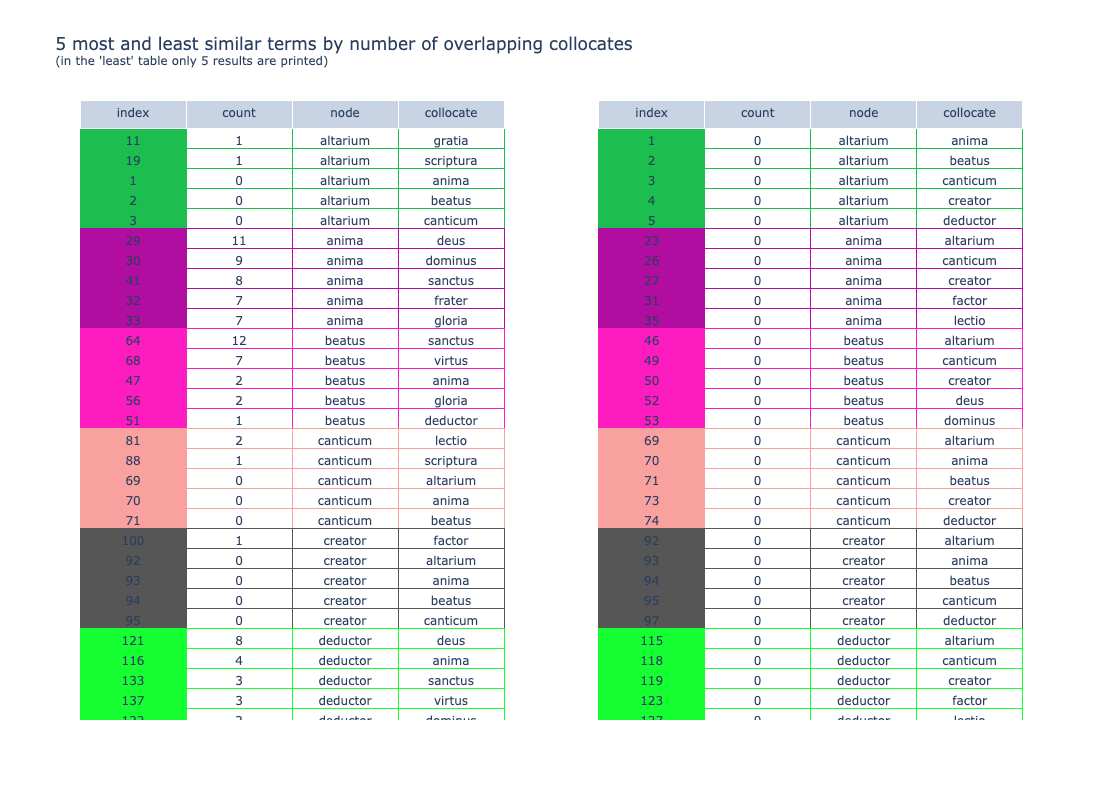

In [45]:
# most ...
fig1 = showLongTable(collDiffs.getNTop(df, top=5, ascending=False), show=False,
                     color="node", 
                     colormap=color_discrete_map_terms)
# ... and least similar by number of overlapping collocations
fig2 = showLongTable(collDiffs.getNTop(df, top=5, ascending=True), show=False,
                        color="node",
                     colormap=color_discrete_map_terms)

# plot both tables
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "table"},{"type": "table"}]])
fig.add_trace(fig1, row=1, col=1)
fig.add_trace(fig2, row=1, col=2)
fig.update_layout(height=800,
                  title_text="5 most and least similar terms by number of overlapping collocates\
                  <br><sup>(in the 'least' table only 5 results are printed)</sup>"
                 )
fig.show()

In terms of collocational overlap count, the most similar pairs of terms in our set are:

In [48]:
# 10 most similar word pairs in the set (by colloc overlap)
sims_all = collDiffs.getNTop(df, top=-1, ascending=False).sort_values("count",ascending=False).drop_duplicates(
    subset=["node","collocate"])
sims_all[sims_all["node"] != sims_all["collocate"]]
dupes = sims_all.apply(frozenset,axis=1).duplicated()
sims = sims_all[~dupes]

In [49]:
prettyprint = True
sims.nlargest(10,"count").style.background_gradient() if prettyprint else sims.nlargest(10,"count")

The least similar pairs, on the other hand, are:

In [50]:
# 10 most dissimilar terms in the set (by colloc overlap)
sims.nsmallest(10,"count").style.background_gradient() if prettyprint else sims.nsmallest(10,"count")

Let's inspect the collocational overlap of the entire set of terms (~ semantic similarity).

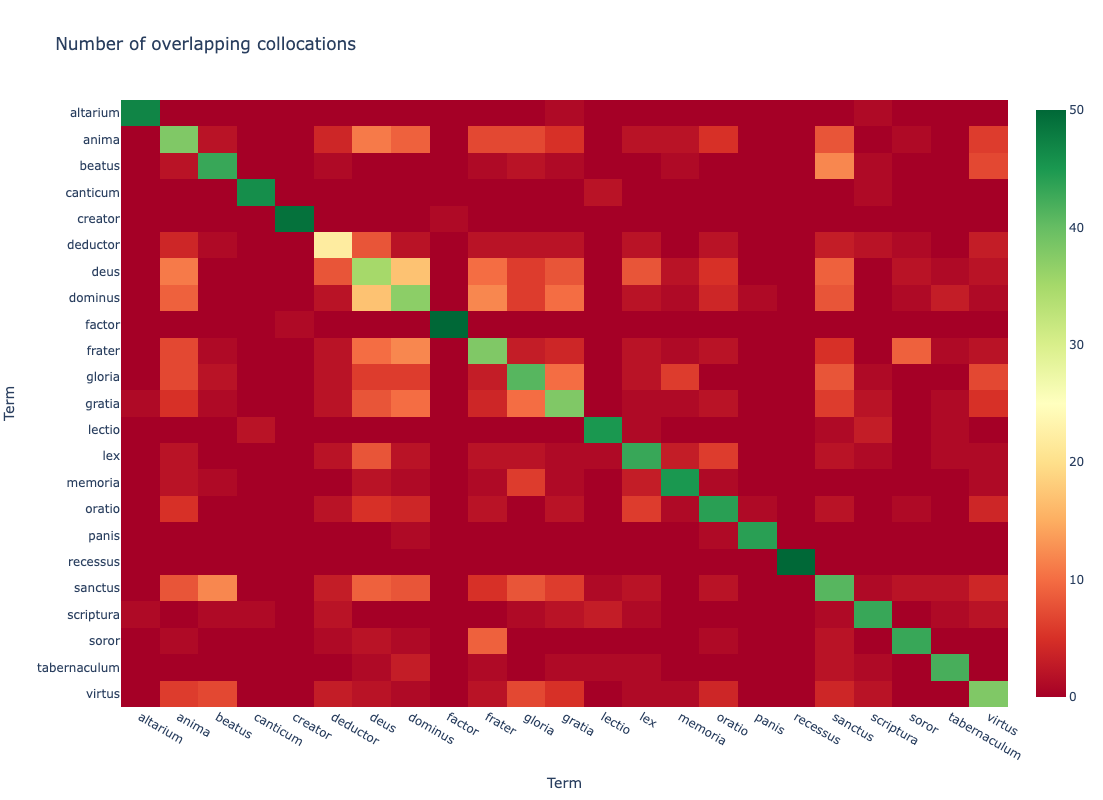

In [51]:
# plot similarity matrix
heatmap = collDiffs.plotCollDf(df, show=False)
heatmap.update_xaxes(title="Term").update_yaxes(title="Term")
heatmap.update_layout(height=800, 
                      title_text="Number of overlapping collocations")
heatmap.show()

In [52]:
# TODO: normalize counts
# TODO: overlaps by the collocate's rank
# TODO: limit display to count > 1

Distributional similarity *via* collocational overlap may be used to discover term clusters.

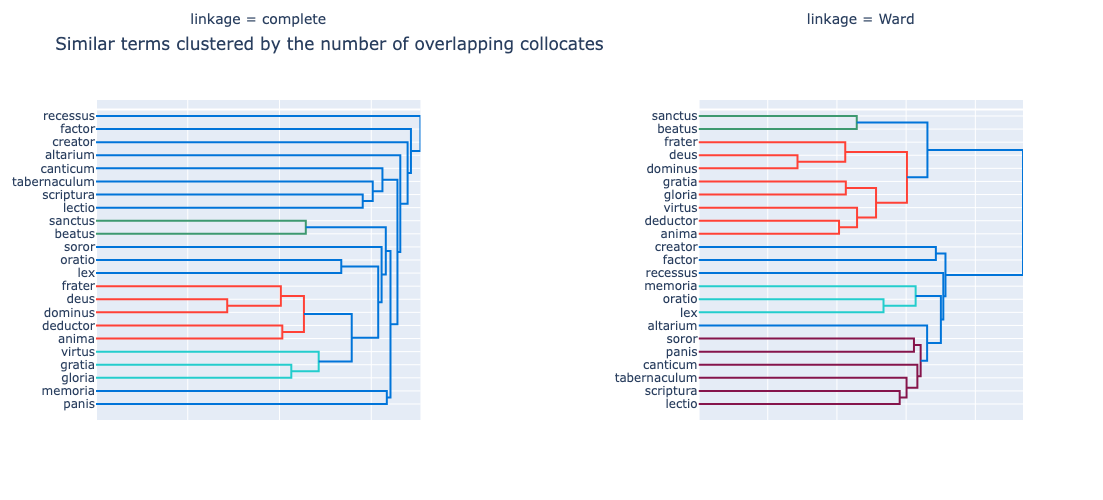

In [53]:
# default linkage method = complete
dendro1 = ff.create_dendrogram(collDiffs.all2all(coll_sets)[2], 
                              orientation='left', labels=labels)
# let's switch linkage method to Ward
dendro2 = ff.create_dendrogram(collDiffs.all2all(coll_sets)[2], 
                              orientation='left', labels=labels, linkagefun=lambda x: sch.linkage(x,'ward'))
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.3)

for data in dendro1['data']:
    fig.add_trace(data, row=1,col=1)
fig.update_xaxes(
    title_text="linkage = complete", row=1, col=1,ticktext=dendro1.layout.yaxis.ticktext,
    showticklabels=False)
fig.update_yaxes(row=1, col=1,ticktext=dendro1.layout.yaxis.ticktext, tickvals=dendro1.layout.yaxis.tickvals)

for data in dendro2['data']:
    fig.add_trace(data, row=1, col=2)
fig.update_xaxes(
    title_text="linkage = Ward", row=1, col=2,
    showticklabels=False)
fig.update_yaxes(row=1, col=2,ticktext=dendro2.layout.yaxis.ticktext, tickvals=dendro2.layout.yaxis.tickvals)


fig.update_layout(title="Similar terms clustered by the number of overlapping collocates",
                  showlegend=False, height=500, width=900)
fig.show()


Theoretically, each of the `christian_terms` can have `(len(christian_terms) -1) * ntop ` (where `ntop` is a number of top collocates taken into consideration) overlapping collocates. This fact may be used to gauge both the semantic coherence of the set as well as "prototypicality" of each of the terms or their semantic distance from other terms in the set.

Let's inspect *total overlap counts* for all terms in the set.

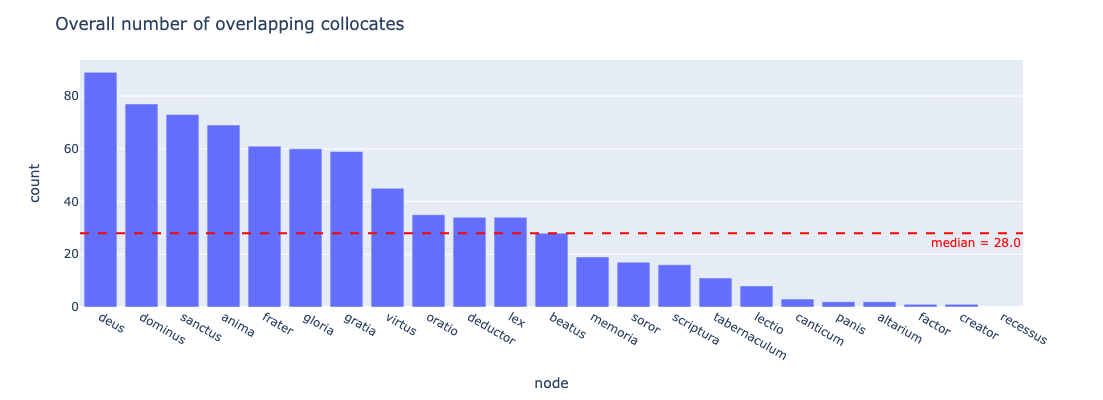

In [54]:
# terms by total number of overlapping collocates (~ set coherence)
sims_all_sum = sims_all[["node", "count"]].groupby("node").sum().reset_index().sort_values("count", ascending=False)
sims_med = sims_all_sum["count"].median()
fig = px.bar(sims_all_sum, x='node', y='count',
             #orientation="h",
             category_orders=[{"node":sims_all_sum["node"]}],
             color_discrete_map=color_discrete_map_terms)
fig.add_hline(y=sims_med, line_color="red", line_dash="dash",
              annotation_text="median = "+str(sims_med), 
              annotation_position="bottom right",annotation_font_color="red")
fig.update_layout(title="Overall number of overlapping collocates", height=400)
fig.show()

In [55]:
# TODO: check how it changes with ranks = [10, 20, ...]

## *Diachronic* collocations

Let's now turn to time-aware collocation counts.

### Data manipulation

As before, to make data manipulation easier, we'll start with converting collocation lists to a Python dictionary.

In [56]:
# convert list of tuples into dict
collocs_time_dict = {}
for item in collocs_time:
    period = item[0]
    term = item[1]
    if collocs_time_dict.setdefault(period) is None:
        collocs_time_dict.setdefault(period)
        collocs_time_dict[period] = {}
    collocs_time_dict[period].setdefault(term, {})
    #print(collocs_time_dict)
    for coll in item[2]:
        coeff = coll[0] # dice etc.
        colls = coll[1] # a list of collocs
        collocs_time_dict[period][term].setdefault(coeff, [])
        
        colls_only = [ list(filter(lambda w: w!=term, bigram)) for bigram in coll[1] ] # only collocates
        colls_only = [ x[0] if len(x) > 0 else term for x in colls_only ] # restores collocates which = term
        
#        collocs_time_dict[period][term][coeff] = colls
        collocs_time_dict[period][term][coeff].append(colls)
        collocs_time_dict[period][term][coeff].append(colls_only)

The collocations for each `period`, `term` and `association_measure` may be accessed as:
`collocs_time_dict[period][term][association_measure]`. The 2-tuple thus retrieved contains the original list of 2-grams and a simplified list of collocates.
For example:

In [57]:
# inspect the dictionary
print("original list ==> ", collocs_time_dict[0]["deus"]["dice"][0], "\n\n", "collocates only ==> ", collocs_time_dict[0]["deus"]["dice"][1])

original list ==>  [('deus', 'immortalis'), ('deus', 'inmortales'), ('deus', 'homo'), ('deus', 'amo'), ('homo', 'deus'), ('pro', 'deus'), ('deus', 'do'), ('templum', 'deus'), ('deus', 'tu'), ('deus', 'deus'), ('deus', 'numen'), ('ira', 'deus'), ('deus', 'deaeque'), ('deus', 'bonus'), ('deus', 'ego'), ('numen', 'deus'), ('deus', 'fides'), ('o', 'deus'), ('ita', 'deus'), ('votum', 'deus'), ('ego', 'deus'), ('ipse', 'deus'), ('deus', 'facio'), ('deus', 'bene'), ('deus', 'templum'), ('deus', 'quis#2'), ('tu', 'deus'), ('per', 'deus'), ('ille', 'deus'), ('si', 'deus'), ('deus', 'omnis'), ('deus', 'placo'), ('ab', 'deus'), ('deus', 'perdo'), ('deus', 'colo'), ('deus', 'ipse'), ('deus', 'ut'), ('deus', 'hic'), ('sacer', 'deus'), ('deus', 'ille'), ('deus', 'hominumque'), ('deus', 'nos'), ('quis#2', 'deus'), ('deus', 'credo'), ('deus', 'nec'), ('deus', 'atque'), ('do', 'deus'), ('sum', 'deus'), ('magnus', 'deus'), ('deus', 'hominesque')] 

 collocates only ==>  ['immortalis', 'inmortales', 'hom

In [58]:
print("original list ==> ", collocs_time_dict[1]["deus"]["dice"][0], "\n\n", "collocates only ==> ", collocs_time_dict[1]["deus"]["dice"][1])

original list ==>  [('dominus', 'deus'), ('deus', 'deus'), ('sum', 'deus'), ('deus', 'sum'), ('deus', 'quis#2'), ('deus', 'et'), ('deus', 'noster'), ('dico#2', 'deus'), ('deus', 'non'), ('deus', 'tuus'), ('deus', 'homo'), ('deus', 'in'), ('deus', 'pater'), ('homo', 'deus'), ('deus', 'omnis'), ('enim', 'deus'), ('quis#2', 'deus'), ('deus', 'meus'), ('christus', 'deus'), ('et', 'deus'), ('in', 'deus'), ('filius', 'deus'), ('deus', 'israel'), ('non', 'deus'), ('quia', 'deus'), ('ab', 'deus'), ('deus', 'facio'), ('ipse', 'deus'), ('deus', 'ut'), ('deus', 'christus'), ('hic', 'deus'), ('deus', 'vos'), ('ad', 'deus'), ('ut', 'deus'), ('quod', 'deus'), ('nos', 'deus'), ('ille', 'deus'), ('deus', 'ille'), ('deus', 'hic'), ('deus', 'ipse'), ('deus', 'suus'), ('sed', 'deus'), ('deus', 'dico#2'), ('facio', 'deus'), ('tu', 'deus'), ('deus', 'nos'), ('ego', 'deus'), ('deus', 'vester'), ('deus', 'autem'), ('deus', 'is')] 

 collocates only ==>  ['dominus', 'deus', 'sum', 'sum', 'quis#2', 'et', 'nost

From the original dictionary, we're deriving a number of data containers, mainly to simplify visualization.

In [59]:
collocs_time_by_term = dict()
for period, collocs in collocs_time_dict.items():
    for term in collocs.keys():
        #period_lbl="period"+str(period)
        period_lbl=periods_labels[period]
        collocs_time_by_term.setdefault(term,{})
        collocs_time_by_term[term].setdefault(period_lbl, [])
        collocs_time_by_term[term][period_lbl] = collocs[term]["dice"][1]
print("collocs_time_by_term is a Python ", type(collocs_time_by_term), "\n" , "collocs_time_by_term[term][period] ==> a list of the collocates of the term in specific period")

collocs_time_by_term is a Python  <class 'dict'> 
 collocs_time_by_term[term][period] ==> a list of the collocates of the term in specific period


In [60]:
# generate (node,collocate,rank) dataframes
collocs_time_by_term_dfs = dict.fromkeys(collocs_time_by_term.keys()) # dictionary of overlap counts
periods = []
for term in collocs_time_by_term_dfs.keys():
    coll_sets_time = []
    for period, colls in collocs_time_by_term[term].items():
        periods.append(period)
        coll_sets_time.append(colls)
    collocs_time_by_term_dfs[term]= collDiffs.collDf(coll_sets = coll_sets_time, labels=periods)
print("collocs_time_by_term_dfs is a ", type(collocs_time_by_term_dfs), "\n" , "collocs_time_by_term_dfs[term] ==> df of the collocates with time period and rank")
collocs_time_by_term_dfs["deus"].head()

collocs_time_by_term_dfs is a  <class 'dict'> 
 collocs_time_by_term_dfs[term] ==> df of the collocates with time period and rank


colloc     slice rank
0  immortalis  -300-150    1
1  inmortales  -300-150    2
2        homo  -300-150    3
3         amo  -300-150    4
4        homo  -300-150    5

Several contain explicit overlap counts.

In [61]:
# overlap counts: by term by period
collocs_time_by_term_mats = dict.fromkeys(collocs_time_by_term.keys()) # dictionary of overlap counts
for term in collocs_time_by_term_mats.keys():
    coll_sets_time = []
    periods = []
    for period, colls in collocs_time_by_term[term].items():
        periods.append(period)
        coll_sets_time.append(colls)
    collocs_time_by_term_mats[term]= collDiffs.all2all(coll_sets = coll_sets_time)[2]

print("collocs_time_by_term_mats is a ", type(collocs_time_by_term_mats), "\n" ,
      "collocs_time_by_term_mats[term] ==> 2D matrix of overlap counts (n_periods, n_periods);\ each row represents total overlap counts of a specific period with other periods\n")

for i, overlap in enumerate(collocs_time_by_term_mats["deus"]):
    print("period: ", i, "overlap count: ", overlap)

collocs_time_by_term_mats is a  <class 'dict'> 
 collocs_time_by_term_mats[term] ==> 2D matrix of overlap counts (n_periods, n_periods);\ each row represents total overlap counts of a specific period with other periods

period:  0 overlap count:  [41 14]
period:  1 overlap count:  [14 36]


In [62]:
# overlap counts: by term: (preceding, following)
collocs_time_by_term_overlap = dict.fromkeys(collocs_time_by_term.keys(),[])
for term in collocs_time_by_term_overlap.keys():
    term_overlap = list() # number of overlapping collocates between (preceding, following) periods
    for i, overlap in enumerate(collocs_time_by_term_mats[term]):
        pre = overlap[i-1] if i > 0 else None
        post = overlap[i+1] if i < len(overlap)-1 else None
        term_overlap.append((pre,post))
    collocs_time_by_term_overlap[term] = term_overlap

# None is set for extreme left and right
#collocs_time_by_term_overlap["deus"]
for i, overlap in enumerate(collocs_time_by_term_overlap["deus"]):
    print("period: ", i, "==> overlap with preceding and following period: ", overlap)

period:  0 ==> overlap with preceding and following period:  (None, 14)
period:  1 ==> overlap with preceding and following period:  (14, None)


In [63]:
# long-format df with overlap counts: term | t_i-1 | t_i | overlap count
overs = []
for term in collocs_time_by_term_mats.keys():
    for period1, overlaps in zip(periods, collocs_time_by_term_mats[term]):
        for period2, overlap in zip(periods, overlaps):
            if period1 != period2:
                overs.append([term, period1, period2, overlap])
overs_df = pd.DataFrame(overs, columns=["term", "source", "target", "count"])
dupes = overs_df.apply(frozenset,axis=1).duplicated() #filter out dupes
overs_df = overs_df[~dupes]

overs_df["term"] = overs_df["term"].astype("category")
# we're making sure the categories are encoded in the same way
overs_df["target"] = pd.Series(overs_df["target"]).astype('category').cat.set_categories(periods)
overs_df["source"] = pd.Series(overs_df["source"]).astype('category').cat.set_categories(periods)
overs_df.head()
#overs_df.tail()

term    source   target  count
0  scriptura  -300-150  150-600      1
2     lectio  -300-150  150-600      3
4       deus  -300-150  150-600     14
6    dominus  -300-150  150-600      2
8    creator  -300-150  150-600      0

### Diachronic collocation overlap
We assume that diachronic collocational overlap (ie. the number of shared collocations between period t_i and t_j) is proportional to semantic similarity of word occurrences and thus indicates the degree of semantic change.

Let's explore this, first, by plotting an overlap (ie. similarity) matrix for each term in our set.

#### Diachronic overlap by term: heatmap

In [64]:
# we'll first define plotting function to facilitate multiplot generation
def build_multiplot(cols, subplot_type, n_items, subplot_titles, **kwargs):
    rows = divmod(n_items, cols)[0] + 1 if divmod(n_items, cols)[1] > 0 else divmod(n_items, cols)[0]
    rows_cols = [ (col, row) for col, row in itertools.product(range(1,rows+1), range(1,cols+1)) ]
    specs =  [ [ {"type": subplot_type} for col in range(1, cols+1) ] for i in range(1, rows+1) ] if subplot_type is not None else None
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=subplot_titles if subplot_titles is not None else None,
        specs = specs,
        **kwargs
    )
    
    return fig, rows_cols

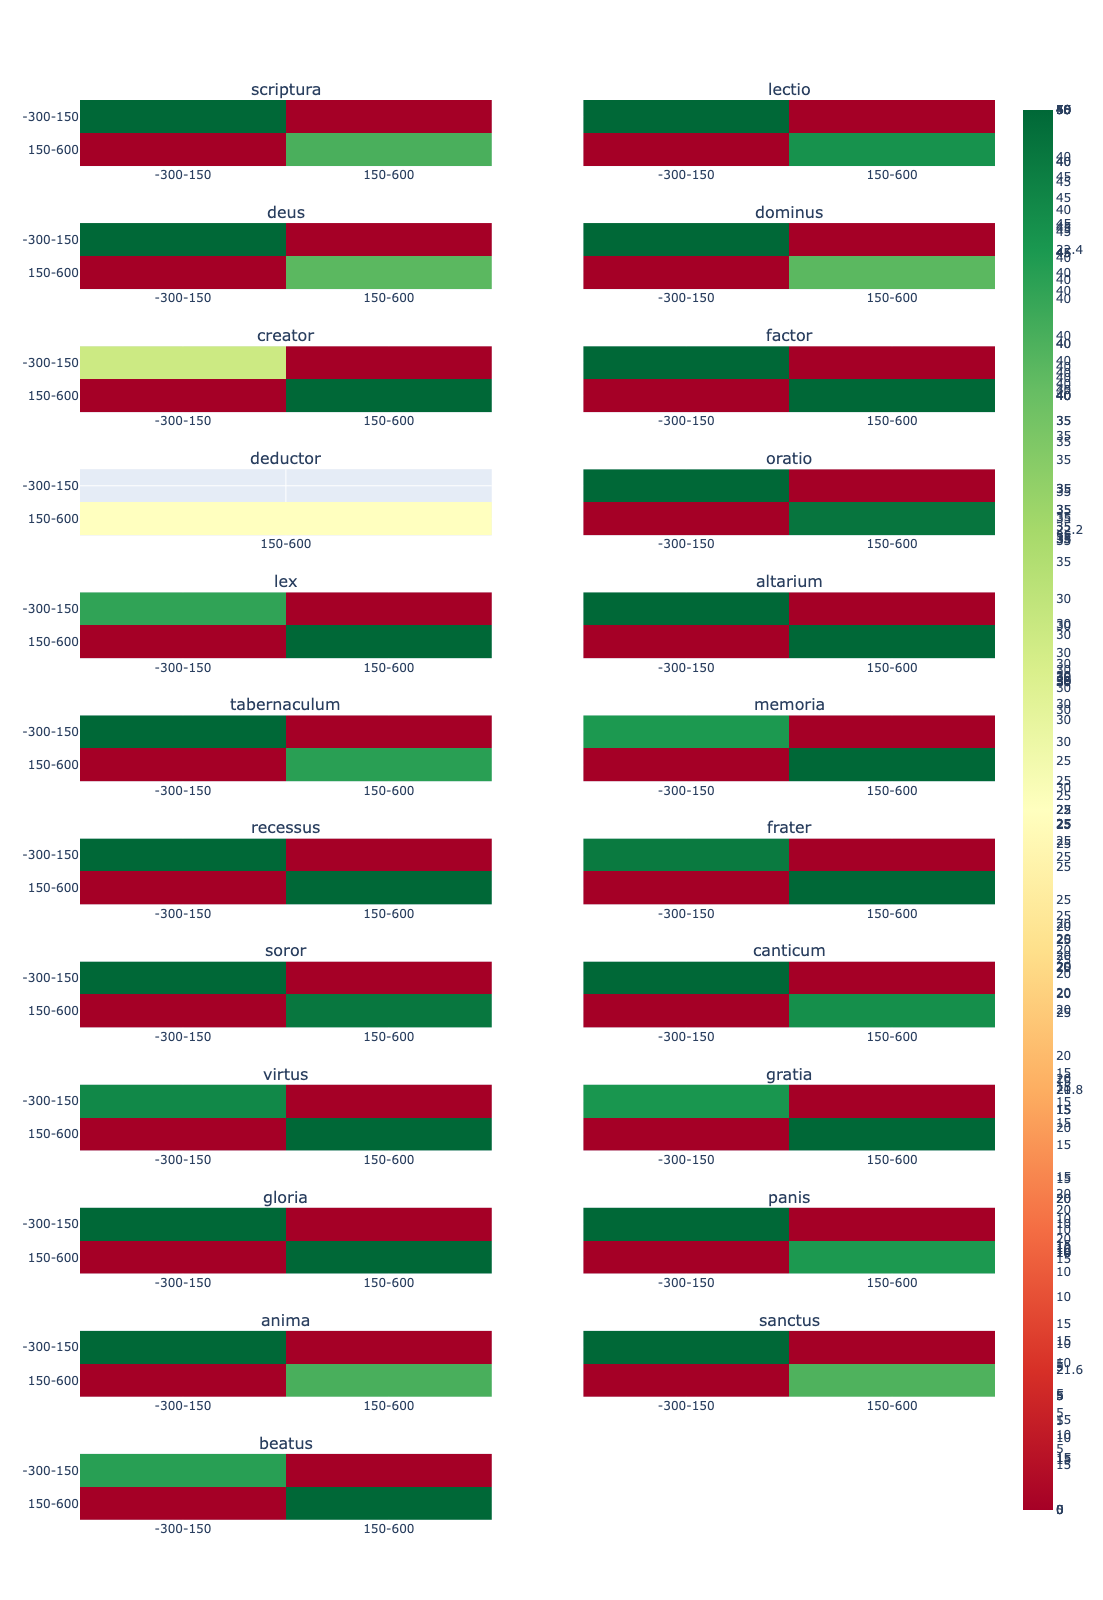

In [65]:
# plot heatmaps for every term
heatmaps = {}
for term, df in collocs_time_by_term_dfs.items():
    fig = collDiffs.plotCollDf(df, show=False)
    fig=fig.update_layout(title="Collocational overlap: "+ term)
    heatmaps.setdefault(term,fig)

fig, rows_cols = build_multiplot(2, None, len(heatmaps), [ term for term in heatmaps.keys() ],
                                 shared_yaxes=True, shared_xaxes=False, vertical_spacing=0.04)

for i, heatmap in enumerate(heatmaps.items()):
    fig.add_trace(heatmap[1]["data"][0], row=rows_cols[i][0], col=rows_cols[i][1])

fig.update_layout(height=1600, showlegend=True)
fig.update_xaxes(
                type="category",
                #title_text="Period",
                categoryorder="category ascending",
            )
fig.update_yaxes(type="category",
                 #title_text="Period",
                 categoryorder="category descending")
fig.show()

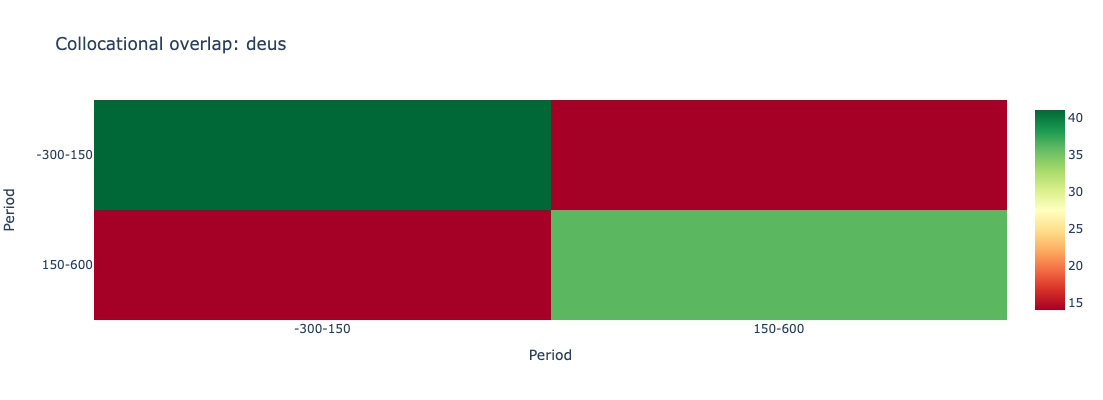

In [66]:
selected="deus"
# plot heatmaps for a single term
fig = collDiffs.plotCollDf(collocs_time_by_term_dfs[selected], show=False)
fig=fig.update_layout(title="Collocational overlap: "+ selected)

fig.update_xaxes(
                type="category",
                #title_text="Period",
                categoryorder="category ascending",
            )
fig.update_yaxes(type="category",
                 #title_text="Period",
                 categoryorder="category descending")
fig.update_layout(height=400, width=400, showlegend=False)
fig.show()

#### Diachronic overlap by term: set intersection

In [67]:
collocs_time_by_term_dfs[selected].head()
selected_collocs = collocs_time_by_term_dfs[selected].groupby("slice")["colloc"].apply(lambda x: x.tolist())

In [68]:
selected_collocs_diff = collDiffs.all2all(selected_collocs)

In [69]:
%pip install matplotlib-venn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


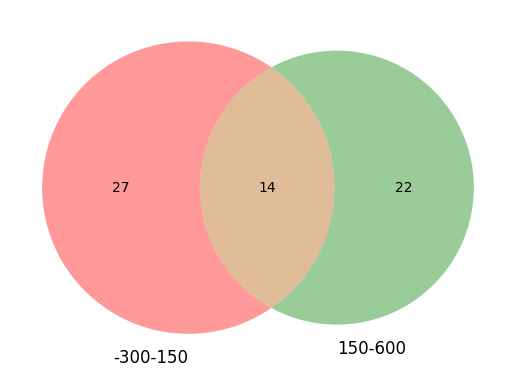

In [70]:
from matplotlib_venn import venn2, venn2_circles
tmp = venn2([set(colls) for colls in selected_collocs], periods_labels)
plt.show()
venn_colors = [ circle.get_facecolor() for circle in tmp.patches ]

In [71]:
# printing collocs in every Venn's subset (following: https://github.com/konstantint/matplotlib-venn/blob/4e0d418ef9f7c9079aeb1139ae185b3b34fa2068/matplotlib_venn/_venn2.py#L117)
a, b = [ set(x) for x in selected_collocs ]
selected_collocs_diffs = []
selected_collocs_diffs.append(a - b)
selected_collocs_diffs.append(b - a)
selected_collocs_diffs.append(a & b)
for l in selected_collocs_diffs:
    print(len(l))
    print(*sorted(l), sep=", ")

27
amo, atque, bene, bonus, colo, credo, deaeque, do, fides, hominesque, hominumque, immortalis, inmortales, ira, ita, magnus, nec, numen, o, per, perdo, placo, pro, sacer, si, templum, votum
22
ad, autem, christus, dico#2, dominus, enim, et, filius, in, is, israel, meus, non, noster, pater, quia, quod, sed, suus, tuus, vester, vos
14
ab, deus, ego, facio, hic, homo, ille, ipse, nos, omnis, quis#2, sum, tu, ut


#### Diachronic overlap by term: line plot

In [72]:
# itertools.pairwise() not defined until Python 3.10, so use the following if running earlier version of Python
def pairwise(iterable):
    "Generate pairs from iterable as (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# period_i:period_i+1 overlap dataframe 
def simple_overlap(overlap_dict, periods):
    periods_diffs = [ x+" : "+y for x,y in pairwise(periods)]    
    overlaps = list()
    for term, overlap_arr in overlap_dict.items():
        #overlaps.setdefault(term,)
        for i, per_diff in enumerate(overlap_arr[0:len(overlap_arr)-1]):
            overlaps.append([term, periods_diffs[i], per_diff[1]])
    df = pd.DataFrame(overlaps)
    df.columns = ["term", "period", "overlap"]
    return df

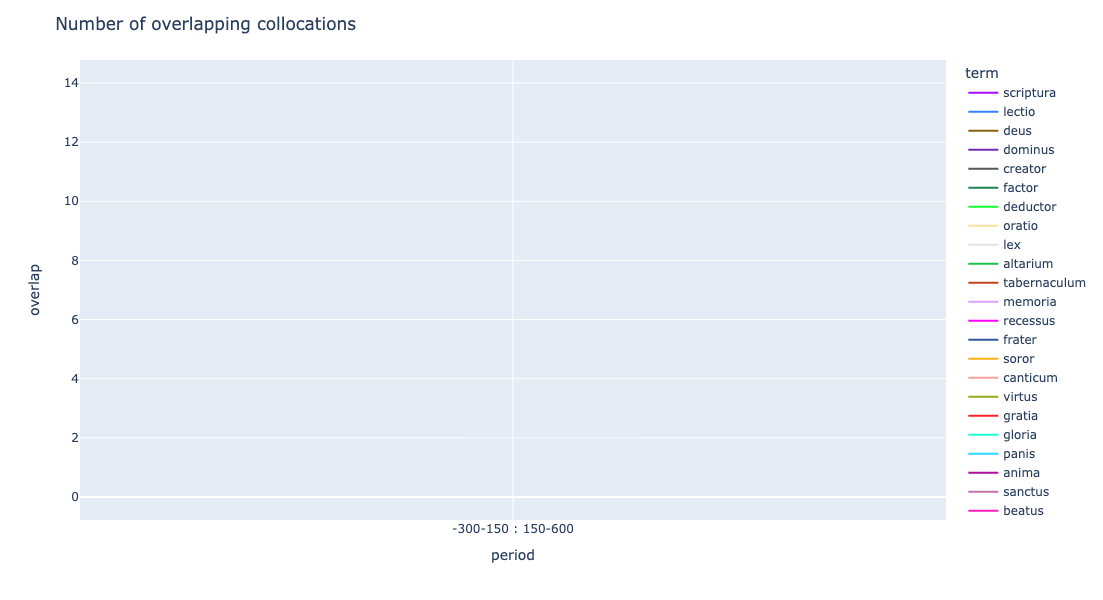

In [74]:
df = simple_overlap(collocs_time_by_term_overlap, periods)

# all
fig_all = px.line(df, x="period",y="overlap",
                  color="term", color_discrete_map=color_discrete_map_terms,
                 ) # filter out empty period
fig_all.update_layout(title="Number of overlapping collocations", height=600)
fig_all.show()

# TODO: plot change ratio instead of change count

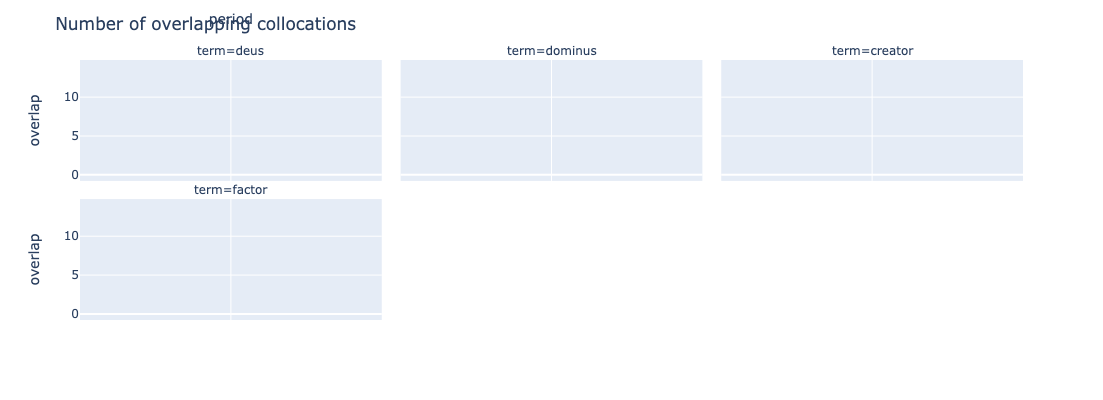

In [75]:
# by term
selected_s = ['deus', 'dominus', 'factor', 'creator']

df_term = df
#df_term["period"] = [ for t1, t2 in df_term["period"].map(lambda x: x.split(':')) ] #shorter labels

if prettyprint:
    fig_by_term = px.line(df_term[df_term["term"].isin(selected_s)],
                      x="period", y="overlap", color="term", # filter out empty period
                      color_discrete_map=color_discrete_map_terms,
                      facet_col="term", facet_col_wrap=3,                      
                     )
    fig_by_term.update_layout(title="Number of overlapping collocations", height=400, showlegend=False)
    fig_by_term.update_xaxes(ticks='', showticklabels=False, tickangle=45, tickfont=dict(size=8))
else:
    fig_by_term = px.line(df_term,
                      x="period", y="overlap", color="term", # filter out empty period
                      color_discrete_map=color_discrete_map_terms,
                      facet_col="term", facet_col_wrap=5,                      
                     )
    fig_by_term.update_layout(title="Number of overlapping collocations", height=800, showlegend=False)
    fig_by_term.update_xaxes(ticks='', showticklabels=True, tickangle=45, tickfont=dict(size=8))
    
fig_by_term.show()

In [ ]:
# by period ()
fig = px.box(df,
             y="overlap", facet_col="period", facet_col_wrap=4, facet_col_spacing=0,
             notched=True, points="all", hover_data=["term", "overlap", "period"],
             color="period", boxmode="overlay",
            )
fig.update_traces(jitter=0, showlegend=False)
fig.update_layout(title="Variation of the overlap counts (by period)", height=400, showlegend=False)
fig.show()

In [ ]:
if prettyprint:
    # by word
    fig = px.box(df[df["term"].isin(selected_s)],
                 y="overlap", x="term",
                 #facet_col="period",
                 notched=False, 
                 points="all",
                 hover_data=["term", "overlap", "period"],
                 color="term", color_discrete_map=color_discrete_map_terms
                )
    fig.update_traces(jitter=0, showlegend=False)
    fig.update_layout(title="Variation of the overlap counts (by term)",
                      height=300, showlegend=False, template="simple_white")
else:
    # by word
    fig = px.box(df,
                 y="overlap", x="term",
                 #facet_col="period",
                 notched=False, 
                 points="all",
                 hover_data=["term", "overlap", "period"],
                 color="term", color_discrete_map=color_discrete_map_terms
                )
    fig.update_traces(jitter=0, showlegend=False)
    fig.update_layout(title="Variation of the overlap counts (by term)", height=300, showlegend=False)
fig.show()

#### Diachronic overlap by term: sankey diagram

In [ ]:
#terms_colors = [ color_discrete_map_terms[t] for t in overs_df_all["term"] ]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      line = dict(color = "black", width = 0),
        label =  list(overs_df["source"].unique())
    ),
    # Add links
    link = dict(
      source =  overs_df["source"].cat.codes,
      target =  overs_df["target"].cat.codes,
      value =  overs_df["count"],
      label =  overs_df["term"],
))])

fig.update_layout(title_text="Total diachronic collocation overlap", font_size=20)
fig.show()

In [ ]:
# prepare sankey chart of collocational overlap for every term in our set
sankeys = []
for term in christian_terms:
    overs_df_this = overs_df[overs_df["term"] == term].copy()
    terms_colors = [ color_discrete_map_terms[t] for t in overs_df_this["term"] ]
    fig = go.Sankey(
        arrangement="snap",
        node = dict(            
            pad = 0,
            thickness = 30,
            line = dict(color = "black", width = 0.5),
            x=[x*10 for x in range(len(periods),1)], #we force the order in which periods are plotted,
            y=[i*10 for i in range(len(periods)) ],
            label =  overs_df_this["source"].unique(),            
        ),
        # Add links
        link = dict(
            source =  overs_df_this["source"].cat.codes,
            target =  overs_df_this["target"].cat.codes,
            value =  overs_df_this["count"],
            line = dict(color = terms_colors, width = 0)
        ))
    sankeys.append(fig)
    
fig, rows_cols = build_multiplot(3, "sankey", len(sankeys), christian_terms,
                                 shared_yaxes=True, shared_xaxes=False, vertical_spacing=0.04)

for i, sankey in enumerate(sankeys):
    fig.add_trace(sankey, row=rows_cols[i][0], col=rows_cols[i][1])

fig.update_layout(height=1200, title_text="Diachronic collocation overlap by term")
fig.show()

### Clustering diachronic collocations

Until now, we have treated diachronic collocation sets as unstructured monoliths. In this section, we resort to word embeddings and clutering techniques in order to investigate fine-grained diachronic changes.

#### Data manipulation

We will employ word2vec embeddings to assess semantic distance between collocates.

In [ ]:
collocs_corpus_all = CorpusFromDir("/Users/valentinalunardi/Documents/UCLA_PhD/Thesis/Metadata_corrections/preprocessed_lemmas_2024")
collocs_corpus = filter(lambda x: x[-4:] == '.txt', collocs_corpus_all)
print(collocs_corpus_all)

In [ ]:
model_file = os.path.join("/Users", "valentinalunardi", "Documents", "UCLA_PhD", "Thesis", "Collocations", "w2v_model", "latinise_w2v_v100w5min5")
#'/home/krzys/Kod/streamlit/voces/data/models/latinise_IT/latinise_w2v_v100w5min5'

if rebuild == True:
    collocs_corpus = CorpusFromDir("/Users/valentinalunardi/Documents/UCLA_PhD/Thesis/Metadata_corrections/preprocessed_lemmas_2024")
    #("/media/HOME_FOLDERS/krzys/Kod/streamlit/voces/data/corpora/latinise_IT_lemmas")
    collocs_model = BuildModels(collocs_corpus)
    mods = dict(word2vec=dict(vector_size=[100], # define parameters
                      window=[5],
                      min_count=[5]))
    
    latinise_w2v_v100w5min5 = collocs_model.build_many(mods)
    latinise_w2v_v100w5min5["word2vec"][0].save(model_file)
    
    model = latinise_w2v_v100w5min5["word2vec"][0]

elif rebuild == False:
    model = Word2Vec.load(model_file)

We can now annotate collocates with vectors retrieved from the word2vec model.

In [ ]:
all_collocs_time = pd.concat(collocs_time_by_term_dfs) # all collocates for all terms for all periods

In [ ]:
collocs = all_collocs_time["colloc"].unique() # only collocates

# find word2vec vectors for each collocate
coll_vecs = [ model.wv[x]
             if x in model.wv.key_to_index.keys() else np.repeat(None, model.wv.vector_size)
             for x in collocs ]

coll_vecs_df=pd.DataFrame(coll_vecs)
coll_vecs_df.index = collocs
not_in_model = coll_vecs_df.isna().all(axis=1)

print( len(coll_vecs_df.loc[not_in_model].index), " words weren't found in the word2vec dictionary, eg. ", [ x for x in coll_vecs_df.loc[not_in_model].index[0:10] ] )

coll_vecs_df = coll_vecs_df.loc[~not_in_model] # exclude collocates which are not found in the word2vec dictionary
coll_vecs_df.head()

#### Cluster computation

Each collocate will be assigned to a cluster basing on the vector. In this study, we use **k-means clustering** with an arbitrary number of **10 clusters**.

In [ ]:
cluster_n = 10
kmeans = KMeans(n_clusters=cluster_n).fit_predict(coll_vecs_df) # (1) initialize the model and (2) fit and return predictions
kmeans_dict = dict(zip(coll_vecs_df.index ,kmeans)) # for easy access we create a dictionary: {"term", "cluster"}
cluster_color_map = { str(i) : px.colors.qualitative.Safe[i] for i in range(0,cluster_n+1) } # for each term we fix a color

We can now annotate all collocates with cluster label.

In [ ]:
all_collocs_time["kmeans_cluster"] = pd.Categorical(all_collocs_time.apply(lambda x: str(kmeans_dict[x["colloc"]]) if x["colloc"] in kmeans_dict.keys() else None, axis=1 ))
all_collocs_time = all_collocs_time.reset_index(level=1, drop=True)
all_collocs_time = all_collocs_time.reset_index()
all_collocs_time = all_collocs_time.rename(columns={"index":"term"})
all_collocs_time

In [ ]:
# print collocs for selected term
all_collocs_time[all_collocs_time["term"] == 'deus'].head()
fig1 = showLongTable(all_collocs_time[(all_collocs_time["term"] == 'deus') & 
                                     (all_collocs_time["slice"] == '-300-150')], show=False,
                     color="kmeans_cluster",
                     colormap=cluster_color_map
                    )
fig2 = showLongTable(all_collocs_time[(all_collocs_time["term"] == 'deus') & 
                                     (all_collocs_time["slice"] == '150-600')], show=False,
                     color="kmeans_cluster",
                     colormap=cluster_color_map
                    )
# fig3 = showLongTable(all_collocs_time[(all_collocs_time["term"] == 'deus') & 
#                                      (all_collocs_time["slice"] == '450-900')], show=False,
#                      color="kmeans_cluster",
#                      colormap=cluster_color_map
#                     )

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "table"},{"type": "table"}]])
fig.add_trace(fig1, row=1, col=1)
fig.add_trace(fig2, row=1, col=2)
fig.update_layout(height=800,
                  title_text="Collocates by period"
                 )
fig.show()

In [ ]:
all_collocs_time[(all_collocs_time["term"] == 'deus')].to_csv('out/deus_collocs.csv')

#### Distribution of collocation clusters through time

In [ ]:
fig = px.histogram(all_collocs_time.sort_values("kmeans_cluster"), x="slice",
                   color="kmeans_cluster", color_discrete_map=cluster_color_map,
                   barmode="stack",
                   category_orders={"kmeans_cluster":'category ascending'},
                   )
fig.update_xaxes(title="Period", categoryorder="category ascending" )
fig.update_yaxes(title="Count")
fig.update_layout(title="Diachronic distribution of collocational clusters (all terms)")
fig.show()

In [ ]:
fig = px.histogram(all_collocs_time.sort_values("kmeans_cluster"),
                   x="slice", color=("kmeans_cluster"), color_discrete_map=cluster_color_map,
                   barmode="stack",
                   category_orders={"kmeans_cluster":'category ascending'},
                   facet_col="term",
                   facet_col_wrap=3,
                   facet_row_spacing=0.06,
                   facet_col_spacing=0.06,)
fig.update_xaxes(title="Period", categoryorder="category ascending" )
fig.update_yaxes(title="Count")
fig.update_layout(height=1400, showlegend=True, title="Diachronic distribution of collocational clusters (by term)")
fig.show()

In [ ]:
fig = px.histogram(all_collocs_time, x="slice", color="kmeans_cluster", barmode="group",
                   facet_col="term", color_discrete_map=cluster_color_map,
                   facet_col_wrap=2,
                   category_orders={"kmeans_cluster":[str(i) for i in range(0,cluster_n+1) ]},
                   facet_row_spacing=0.06,
                   facet_col_spacing=0.06,
                   )
                  
fig.update_xaxes(title="Period", showticklabels=True)
fig.update_yaxes(title="Count")
fig.update_layout(height=2000, showlegend=True, title="Diachronic distribution of collocational clusters (by term)")
fig.show()

In [ ]:
df = pd.DataFrame(all_collocs_time.groupby(["slice", "term"])["kmeans_cluster"].value_counts().reset_index())
df.columns = ["slice", "term","kmeans_cluster", "count"]
#df[df["term"] == 'deus'].head()

fig = px.area(df, x="slice", color="kmeans_cluster", color_discrete_map=cluster_color_map,
                  y="count", category_orders={"kmeans_cluster":[str(i) for i in range(0,cluster_n+1) ]},
                   facet_col="term", facet_col_wrap=4,
                   facet_row_spacing=0.06, facet_col_spacing=0.04,
                   )
fig.update_xaxes(title="", categoryorder="category ascending", showticklabels=True, tickangle=45)
fig.update_layout(height=1400, showlegend=True, title="Diachronic distribution of collocational clusters (by term)")
fig.show()

In [ ]:
fig = px.histogram(all_collocs_time,
                   x="kmeans_cluster", color="kmeans_cluster",
                   barmode="group",
                   facet_col="term",
                   color_discrete_map=cluster_color_map,
                   facet_col_wrap=5, 
                   animation_frame="slice", animation_group="kmeans_cluster",
                   category_orders={"kmeans_cluster":[str(i) for i in range(0,cluster_n+1) ]},
                   facet_row_spacing=0.04, facet_col_spacing=0.04,
                   )

fig.update_layout(height=800, showlegend=True, title="Interactive diachronic distribution of collocational clusters (by term)")
fig.show()

#### Variation of collocation clusters through time
Let's assume that the distribution of collocational clusters of a term at time_i corresponds to its semantics at this point in time. Diachronic variation of the counts may help us in assessing if the term was subject to important sense changes.

**TODO** It might be better, though, to evaluate the cross-cluster variation rather than one-cluster counts.

In [ ]:
fig = px.box(df.sort_values("kmeans_cluster"), x="kmeans_cluster",
             color="kmeans_cluster", color_discrete_map=cluster_color_map,
             y="count",
             facet_col="term", facet_col_wrap=2,
             facet_row_spacing=0.02, facet_col_spacing=0.02,
             category_orders={"kmeans_cluster":'category ascending'},
            )
fig.update_xaxes(title="", categoryorder="category ascending", showticklabels=True, tickangle=45)
fig.update_layout(height=2000, showlegend=True, title="Variation of collocational clusters counts (by cluster)")
fig.show()

In [ ]:
# TODO: variation by genre

### Semantic relatedness of collocations through time

#### Data manipulation

We're evaluating semantic (dis)similarity of collocates based on vectors retrieved from the word2vec model. To facilitate analyses, we are building similarity matrix for all collocates at once.

In [ ]:
print("The model we'll be using: ", model, ".\n")
similarity_matrix = np.matrix([ model.wv.cosine_similarities(vec1, coll_vecs_df) for vec1 in coll_vecs_df.to_numpy() ])
print("Our similarity matrix has shape: ", similarity_matrix.shape, "\n", similarity_matrix[0:2])
#dist_matrix = distance.pdist(np.ndarray([ coll_vecs_df[0:2], coll_vecs_df[0:2]]).dropna(), metric='cosine')

Also, for plotting purposes, we are reducing vectors to 2 dimensions with the t-SNE.

In [ ]:
tsne_df = all_collocs_time[["colloc", "slice", "term", "rank"]].reset_index(drop=True)
tsne_df = tsne_df.set_index("colloc", drop=False)
tsne_df["vec"] = [ coll_vecs_df.loc[colloc] if colloc in coll_vecs_df.index else None for colloc in tsne_df["colloc"] ]
tsne_df = tsne_df[ ~ tsne_df["vec"].isna()] # exclude collocates not in the word2vec dict

# fit TSNE
vecs = tsne_df["vec"]
vecs = np.array([ vec for vec in vecs ])
tsne = TSNE(n_components=2, random_state=0, 
            init='pca', learning_rate="auto", metric="cosine", perplexity=len(periods))
coords = tsne.fit_transform( vecs )

# add (x,y) coordinates to each row
tsne_df["x"] = [ coord[0] for coord in coords ]
tsne_df["y"] = [ coord[1] for coord in coords ]
tsne_df["rank"] = pd.to_numeric(tsne_df["rank"])

tsne_df.head()

#### Semantic relatedness of diachronic collocations: zoom on node word

Diachronic collocations may be clustered based on their semantic similarity.

In [ ]:
# all: only strongest collocates
topn = 10
tsne_df[tsne_df["rank"] <= topn ]
fig = px.scatter(tsne_df[tsne_df["rank"] <= topn], x="x", y="y", color="slice", text="colloc", facet_col="term",
                 facet_col_wrap=3, facet_row_spacing=0.01)
fig.update_layout(height=2000)
fig.show()

The same data may be visualized dynamically.

In [ ]:
# all: only strongest collocates
topn = 20
fig = px.scatter(tsne_df[tsne_df["rank"] <= topn], x="x", y="y", color="slice", text="colloc", facet_col="term",
                 animation_frame="slice",
                 facet_col_wrap=3, facet_row_spacing=0.01)
fig.update_layout(height=2000, showlegend=False)
fig.show()

Usually, it is easier to analyze terms one by one.

In [ ]:
# all: only strongest collocates
topn = 25
term = 'deus'
fig = px.scatter(tsne_df[ (tsne_df["rank"] <= topn) & (tsne_df["term"] == term) ],
                 x="x", y="y", color="slice", text="colloc",
                 animation_frame="slice",
                
                )
fig.update_traces(marker_size=1, textfont=dict(size=12))
fig.update_layout(height=400, showlegend=False, template = "simple_white", )
fig.show()

In [ ]:
# all: only strongest collocates
topn = 25
term = 'deus'
fig = px.scatter(tsne_df[ (tsne_df["rank"] <= topn) & (tsne_df["term"] == term) ],
                 x="x", y="y", color="slice", text="colloc",
                 facet_row="slice"
                 #animation_frame="slice",
                
                )
fig.update_traces(marker_size=1, textfont=dict(size=10))
fig.update_layout(height=600, width = 800, showlegend=False, template = "simple_white", )
fig.show()

#### Semantic relatedness of diachronic collocations: zoom on period
Let's evaluate semantic similarity of all collocates of all terms for each period.

**TODO** The plot is, however, hardly legible and difficult to interpret.

In [ ]:
# all: only strongest collocates - by period - unreadable
topn = 10
tsne_df[tsne_df["rank"] <= topn ]
fig = px.scatter(tsne_df[tsne_df["rank"] <= topn], x="x", y="y",
                 color="term", text="colloc", color_discrete_map=color_discrete_map_terms,
                 #facet_col="term",
                 facet_row="slice",
                 facet_col_wrap=2,
                 facet_row_spacing=0.01)
fig.update_layout(height=2000, title="Semantic relatedness of collocates through time")
fig.show()

#### Semantic change of the diachronic collocation sets

Let's assume that semantic value of a collocational set at the point t_i is approximated by the mean of the vectors of its elements.

In [ ]:
# TODO: Evaluate if and how the mean is correlated with the rank of collocates included in the set.

First, we calculate vector means for each term-period.

In [ ]:
df_sims = tsne_df[~ tsne_df["vec"].isna() ].groupby(["term","slice"])["vec"].aggregate(lambda x: cosine_similarity([y for y in x]) ).reset_index()
df_sims["mean_sim"] = df_sims.apply(lambda x: np.mean(np.tril(x["vec"], k=-1)), axis=1 ) # get the lower triangle of the matrix
df_sims["std_sim"] = df_sims.apply(lambda x: np.std(np.tril(x["vec"], k=-1)), axis=1 )


We are now ready to plot the means for each term for each period. If the mean of collocation set vectors significantly changes, we may suppose the meaning of the term changed as well.

In [ ]:
fig = px.line(
    df_sims,
    x="slice",
    y="mean_sim",
    color="term", color_discrete_map=color_discrete_map_terms,
    facet_col="term", facet_col_wrap=3, facet_row_spacing=0.09, facet_col_spacing=0.06
) # collocational set coherence
fig.update_layout(height=1200, showlegend=False)
fig.update_yaxes(title="vectors mean")
fig.update_xaxes(title="period", showticklabels=True, tickangle=45)
fig.show()

If the vectors mean is indicative of the word meaning, we may calculate the cosine similarity of the term-periods and plot the on the 2D plane by reducing the vectors with the t-SNE.

In [ ]:
df_sims_vecs = tsne_df[~ tsne_df["vec"].isna() ].copy().groupby(["term","slice"])["vec"].aggregate(vec_mean=lambda x: np.mean( [y for y in x], axis = 0 ) ).reset_index()

# computet coordinates
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate="auto", metric="cosine", perplexity=len(periods)+1)
coords = tsne.fit_transform( np.array([ x for x in df_sims_vecs["vec_mean"] ]) )
df_sims_vecs["x"] = [coord[0] for coord in coords]
df_sims_vecs["y"] = [coord[1] for coord in coords]
df_sims_vecs["label"] = df_sims_vecs.apply(lambda x: x["term"] + ":" + x["slice"], axis=1)
df_sims_vecs.head()

In [ ]:
fig = px.scatter(df_sims_vecs, x="x", y="y",
                 color="term", text="label", color_discrete_map=color_discrete_map_terms,
                )
fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color, textposition='top center'))
fig.update_traces(mode="text")
fig.update_layout(height=800, showlegend=False, title="Distance of term-periods vector means (t-SNE)")
fig.show()

In [ ]:
if prettyprint:
    fig = px.scatter(df_sims_vecs, x="x", y="y",
                 color="term", text="label", color_discrete_map=color_discrete_map_terms,
                )
    fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color, textposition='top center'))
    fig.update_traces(mode="text")
    fig.update_layout(height=500,  width=800,
                      template="simple_white",
                      showlegend=False, title="Distance of term-periods vector means (t-SNE)")
    fig.show()

The cosine similarity of term-periods may be also investigated on a heatmap.

In [ ]:
# similarity between periods and terms
df_sims_vecs_cosine = cosine_similarity([ row for row in df_sims_vecs["vec_mean"] ])

labels = [ row for row in df_sims_vecs["label"] ]
fig = go.Figure(
    data=go.Heatmap(
        x=labels,
        y=labels,
        z=df_sims_vecs_cosine
    )
)
fig.update_layout(height=1000, title="Semantic relatedness of term-periods (vector means)")
fig.update_yaxes(categoryorder='category descending')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

In [ ]:
# heatmap with dendrogram following the example at https://plotly.com/python/dendrogram/#plot-a-dendrogram-with-a-heatmap

data_array = df_sims_vecs_cosine
data_array = data_array.transpose()
labels = [ row for row in df_sims_vecs["label"] ]

# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(data_array, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(data_array, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = distance.pdist(data_array)
heat_data = distance.squareform(data_dist)
heat_data = heat_data[dendro_leaves,:]
heat_data = heat_data[:,dendro_leaves]

heatmap = [
    go.Heatmap(
        x = dendro_leaves,
        y = dendro_leaves,
        z = heat_data,
        colorscale = 'Blues'
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'width':800, 'height':800,
                         'showlegend':False, 'hovermode': 'closest',
                         })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'ticks':""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Edit yaxis
fig.update_layout(yaxis={'domain': [0, .85],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': False,
                                  'ticks': ""
                        })
# Edit yaxis2
fig.update_layout(yaxis2={'domain':[.825, .975],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Plot!
fig.update_layout(height=1000, width=1000)
fig.show()

In [ ]:
# qualitative flow of collocates
collocs_time_by_term_dfs["deus"]

#### Collocational similarity (network approach)

Let's represent collocations of a term or a set of terms as a graph. The node set comprises of all the collocates of a terms or terms as well as the terms themselves. The edges link collocate nodes with the respective term nodes. The edges are assigned a `weight` attribute which defines nodes attraction and whose value is inversely proportional to the collocation rank: $1-(rank/max(rank))$.

**TODO** More rigorous definition.

In [ ]:
net_df = pd.DataFrame()
for term, dataf in collocs_time_by_term_dfs.items():
    dataf = dataf.assign(term = pd.Series([x for x in itertools.repeat(term,len(dataf.index))]))
    net_df = pd.concat([net_df, dataf]) 
net_df['slice_term'] = net_df['term'] + '_' + net_df['slice'].str.replace('period','')
net_df = net_df.assign(weight = pd.to_numeric(1-pd.to_numeric(net_df["rank"])/pd.to_numeric(net_df["rank"]).max()))

net_df.head()

Since collocate nodes may be linked to multiple terms, intuitively, the network may be used to assess degree of semantic relatedness between the terms. To increase legibility we will plot only 20 strongest collocates,

In [ ]:
rank_thresh = 20
g = nx.from_pandas_edgelist(net_df[ pd.to_numeric(net_df["rank"]) <= rank_thresh ],source="colloc", target="term",edge_key="slice",
                            edge_attr=["weight", "slice"], create_using=nx.MultiGraph())

# remove low-degree nodes, ie. nodes that are linked to only 1 node
low_degree = [n for n, d in g.degree() if d < 2]
g.remove_nodes_from(low_degree)
node_colors = [ color_discrete_map_terms[node] if  node in color_discrete_map_terms.keys() else '#808080' for node in g.nodes ]
node_sizes = [ 300 if  node in color_discrete_map_terms.keys() else 0 for node in g.nodes ]
pos = nx.spring_layout(g, seed=1)
if prettyprint:
    plt.figure(1,figsize=(14,8), dpi=800) 
else:
    plt.figure(1,figsize=(20,20)) 
nx.draw_networkx(g, pos, width=0.1, node_color=node_colors, node_size=node_sizes, font_size=8)

The networks may be inspected period by period. 

In [ ]:
graphs = []
rank_thresh = 20
for i, period in enumerate(periods[0:len(periods)]):
    g = nx.from_pandas_edgelist(net_df[ (net_df["slice"] == period) & (pd.to_numeric(net_df["rank"]) <= rank_thresh) ],source="colloc", target="term",edge_key="slice",
                            edge_attr=["weight", "slice"], create_using=nx.MultiGraph())
    # remove low-degree nodes
    low_degree = [n for n, d in g.degree() if d < 2]
    g.remove_nodes_from(low_degree)
    node_colors = [ color_discrete_map_terms[node] if  node in color_discrete_map_terms.keys() else '#808080' for node in g.nodes ]
    node_sizes = [ 300 if  node in color_discrete_map_terms.keys() else 0 for node in g.nodes ]
    font_sizes = [ 12 if  node in color_discrete_map_terms.keys() else 4 for node in g.nodes ]
    pos = nx.spring_layout(g, seed=675, k=0.99)
    graphs.append((g, pos, node_colors, node_sizes, period))

In [ ]:
ncols = 2
nrows = divmod(len(graphs), ncols)[0] if divmod(len(graphs), ncols)[1] == 0 else divmod(len(graphs), ncols)[0] + 1
print(ncols, nrows)
if prettyprint:
    fig, axs = plt.subplots( nrows , ncols, sharex=True, figsize=(30, 20), dpi=300)
    #plt.figure(1,figsize=(14,8), dpi=800) 
else:
    fig, axs = plt.subplots( nrows , ncols, sharex=True, figsize=(20, 30))
    


for i, graph in enumerate(graphs):    
    ax = axs.flatten()
    ax[i].set_title(graphs[i][4])
    nx.draw_networkx(graphs[i][0], graphs[i][1], width=0.1, node_color=graphs[i][2], 
                     node_size=graphs[i][3],
                     font_size=12,
                     ax=ax[i])

Likewise, the (dis)similarity may be evaluated for term-periods. This time, we are using `nx.algorithms.community.greedy_modularity_communities` algorithm with to detect "communities" (ie. sense clusters) in the network. 

**TODO** Improve legibility or remove.

In [ ]:
rank_thresh = 10
g = nx.from_pandas_edgelist(net_df[ pd.to_numeric(net_df["rank"]) <= rank_thresh ],
                            source="colloc", target="slice_term",
                            edge_key="slice",
                            edge_attr=["weight", "slice"], create_using=nx.MultiDiGraph())

# remove low-degree nodes
low_degree = [n for n, d in g.degree() if d < 2]
g.remove_nodes_from(low_degree)

G = g.copy()
communities = nx.algorithms.community.greedy_modularity_communities(G)
communities_cols = [ px.colors.qualitative.Alphabet[i] for i, v in enumerate(communities) ]

communities_dict = {}
for i, comm in enumerate(communities):
    for com in comm:
        communities_dict.setdefault(com, communities_cols[i])

In [ ]:
pos = nx.spring_layout(G,k=0.01)
plt.figure(1,figsize=(14,14))

for node in G.nodes:    
    lbl = node
    #lbl = node.split('_')[0]
    col = communities_dict[lbl]
    nx.draw_networkx_labels(G, pos=pos, labels={node:node}, font_color=col)

nx.draw_networkx_nodes(G, pos,
                       node_size=0,
                       label=[ n for n in G.nodes ],
                       node_color = communities_dict.values())

In [ ]:
# interactive, but slooow!
def plot_pyvis_graph():    
    g_ = network.Network(notebook=True, width="100%")
    g_.from_nx(g)
    g_.show_buttons()

    for node in g_.nodes:
        if node["label"] in color_discrete_map_terms.keys():
            node["color"] = color_discrete_map_terms[node["label"]]

    g_.show('collocs.html')
# uncomment to plotTODOTODO
# plot_pyvis_graph()